# Book Detection with SAM, CLIP, and Google Vision API
#### By Sarthak Dayal, Mukund Raman, and Praneel Seth

Import all required packages:

In [23]:
import io
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from transformers import CLIPProcessor, CLIPModel, TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import itertools

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import matplotlib.pyplot as plt
import supervision as sv
import numpy as np
import torch
import cv2

Set input parameters for retrieving a book title, sample_text, from a sample image:

In [27]:
sample_text = "Robot Modeling and Control"
sample_image = "original_image.jpg"

Use pre-trained models and processors from CLIP:

In [2]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

text_processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
text_model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Define helper functions to help with processing the image:

In [9]:
def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

# Plot the given image
def show_annotated(annotated_image):
    plt.figure(figsize=(20,20))
    plt.imshow(annotated_image)
    
    ax = plt.gca()
    ax.set_autoscale_on(False)
    
    plt.axis('off')
    plt.show()

def resize_image(image_path, size=(1024, 1024)):
    # Open the image file
    with open(image_path, 'rb') as image_file:
        image = Image.open(image_file)
        image = image.resize(size)

        # Save the image back to a byte buffer
        byte_arr = io.BytesIO()
        image.save(byte_arr, format='JPEG')
        byte_arr = byte_arr.getvalue()
    return byte_arr

Load and resize the image and then create the mask generator with all of the fine-tuned parameters:

In [4]:
image = load_image(sample_image)
sam = sam_model_registry["vit_h"](checkpoint="sam_vit_h_4b8939.pth")
sam.to(device="cpu")
image = cv2.resize(image, (1024, 1024), interpolation=cv2.INTER_LINEAR)

mask_generator = SamAutomaticMaskGenerator(
   model=sam,
   points_per_side=32,
   points_per_batch=128,
   pred_iou_thresh=0.98,
   stability_score_thresh=0.97,
   crop_n_layers=1,
   crop_n_points_downscale_factor=2,
   min_mask_region_area=500
)

Use the mask generator to segment the image into a list of masks (may take a while)

In [5]:
masks = mask_generator.generate(image)

Once that's done, annotate the original images with the segmented masks to highlight which objects were detected:

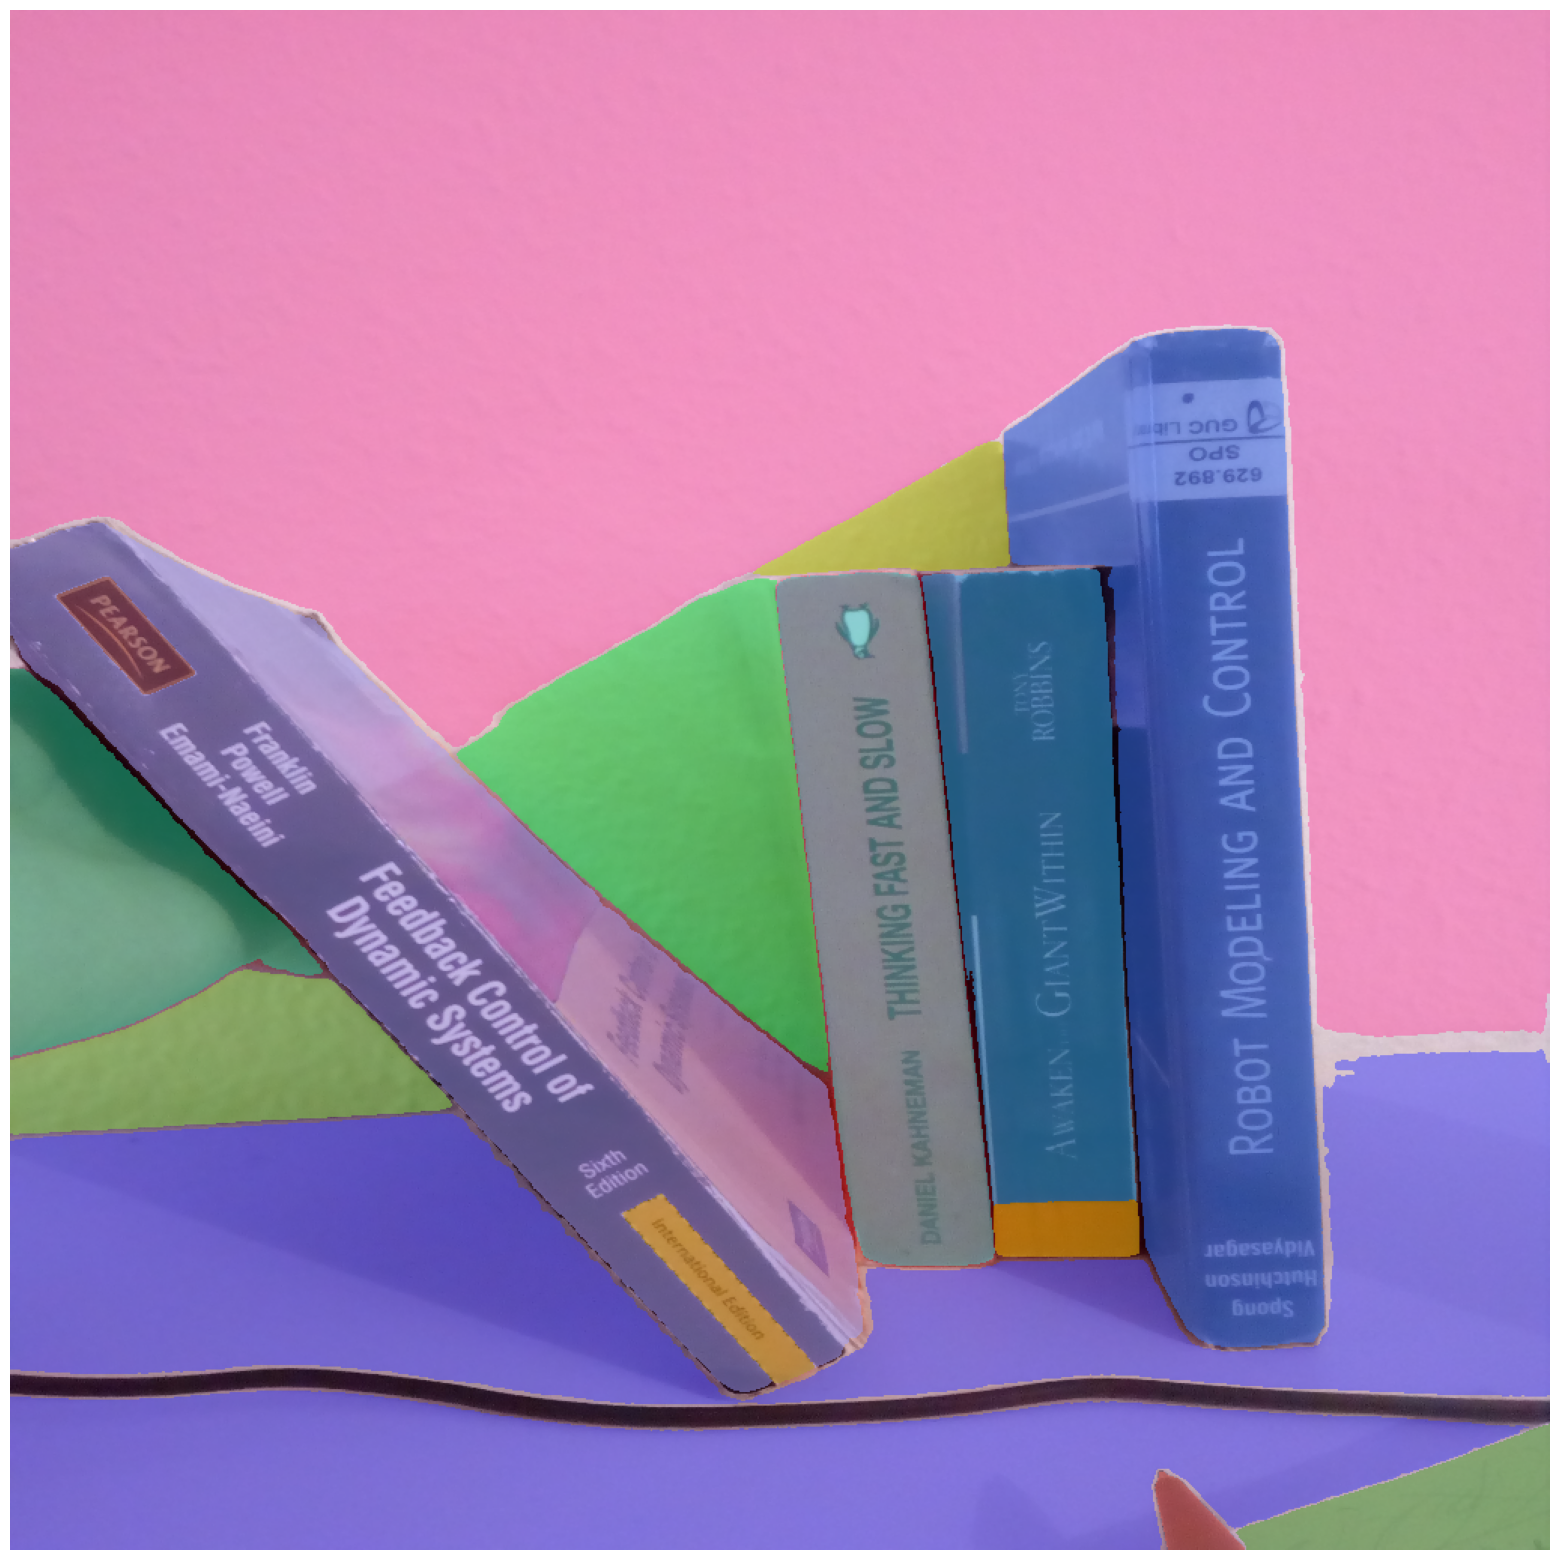

In [6]:
mask_annotator = sv.MaskAnnotator(color_lookup = sv.ColorLookup.INDEX)
detections = sv.Detections.from_sam(masks)
annotated_image = mask_annotator.annotate(image, detections)
show_annotated(annotated_image)

Use CLIP to classify a given segment mask as a book or not a book:

In [7]:
def classify_mask_as_book(masked_img, labels= ["text on book spine", "red book", "tilted book" "something else", "wall"]):
    # Prepare the image for the CLIP model
    pil_image = Image.fromarray(masked_img)
    inputs = processor(text=labels, images=pil_image, return_tensors="pt", padding=True)
    outputs = clip_model(**inputs)

    # Get the predicted label
    logits_per_image = outputs.logits_per_image
    probs = torch.softmax(logits_per_image, dim=1)
    best_label_idx = torch.argmax(probs)
    return labels[best_label_idx] == "red book" or labels[best_label_idx] == "text on book spine" or labels[best_label_idx] == "tilted book"

Iterate through all of the mask segments and filter out non-book segments:

In [11]:
book_segments = []
for i, mask_dict in enumerate(masks):
    # Retrieve the masked image by applying the mask to the original image
    mask = np.repeat(mask_dict['segmentation'][:, :, np.newaxis].astype(np.uint8), 3, axis=2) * 255
    masked_img = image.copy()
    cv2.bitwise_and(image.astype(np.uint8), mask, masked_img)

    # Classify segment as book/non-book
    if classify_mask_as_book(masked_img):
        print(f"Segment {i} is a book")
        book_segments.append(masked_img)
    else:
        print(f"Segment {i} is not a book")

Segment 0 is a book
Segment 1 is a book
Segment 2 is not a book
Segment 3 is not a book
Segment 4 is not a book
Segment 5 is not a book
Segment 6 is not a book
Segment 7 is not a book
Segment 8 is not a book
Segment 9 is not a book
Segment 10 is not a book
Segment 11 is a book
Segment 12 is not a book
Segment 13 is a book
Segment 14 is a book


Display the book segments:

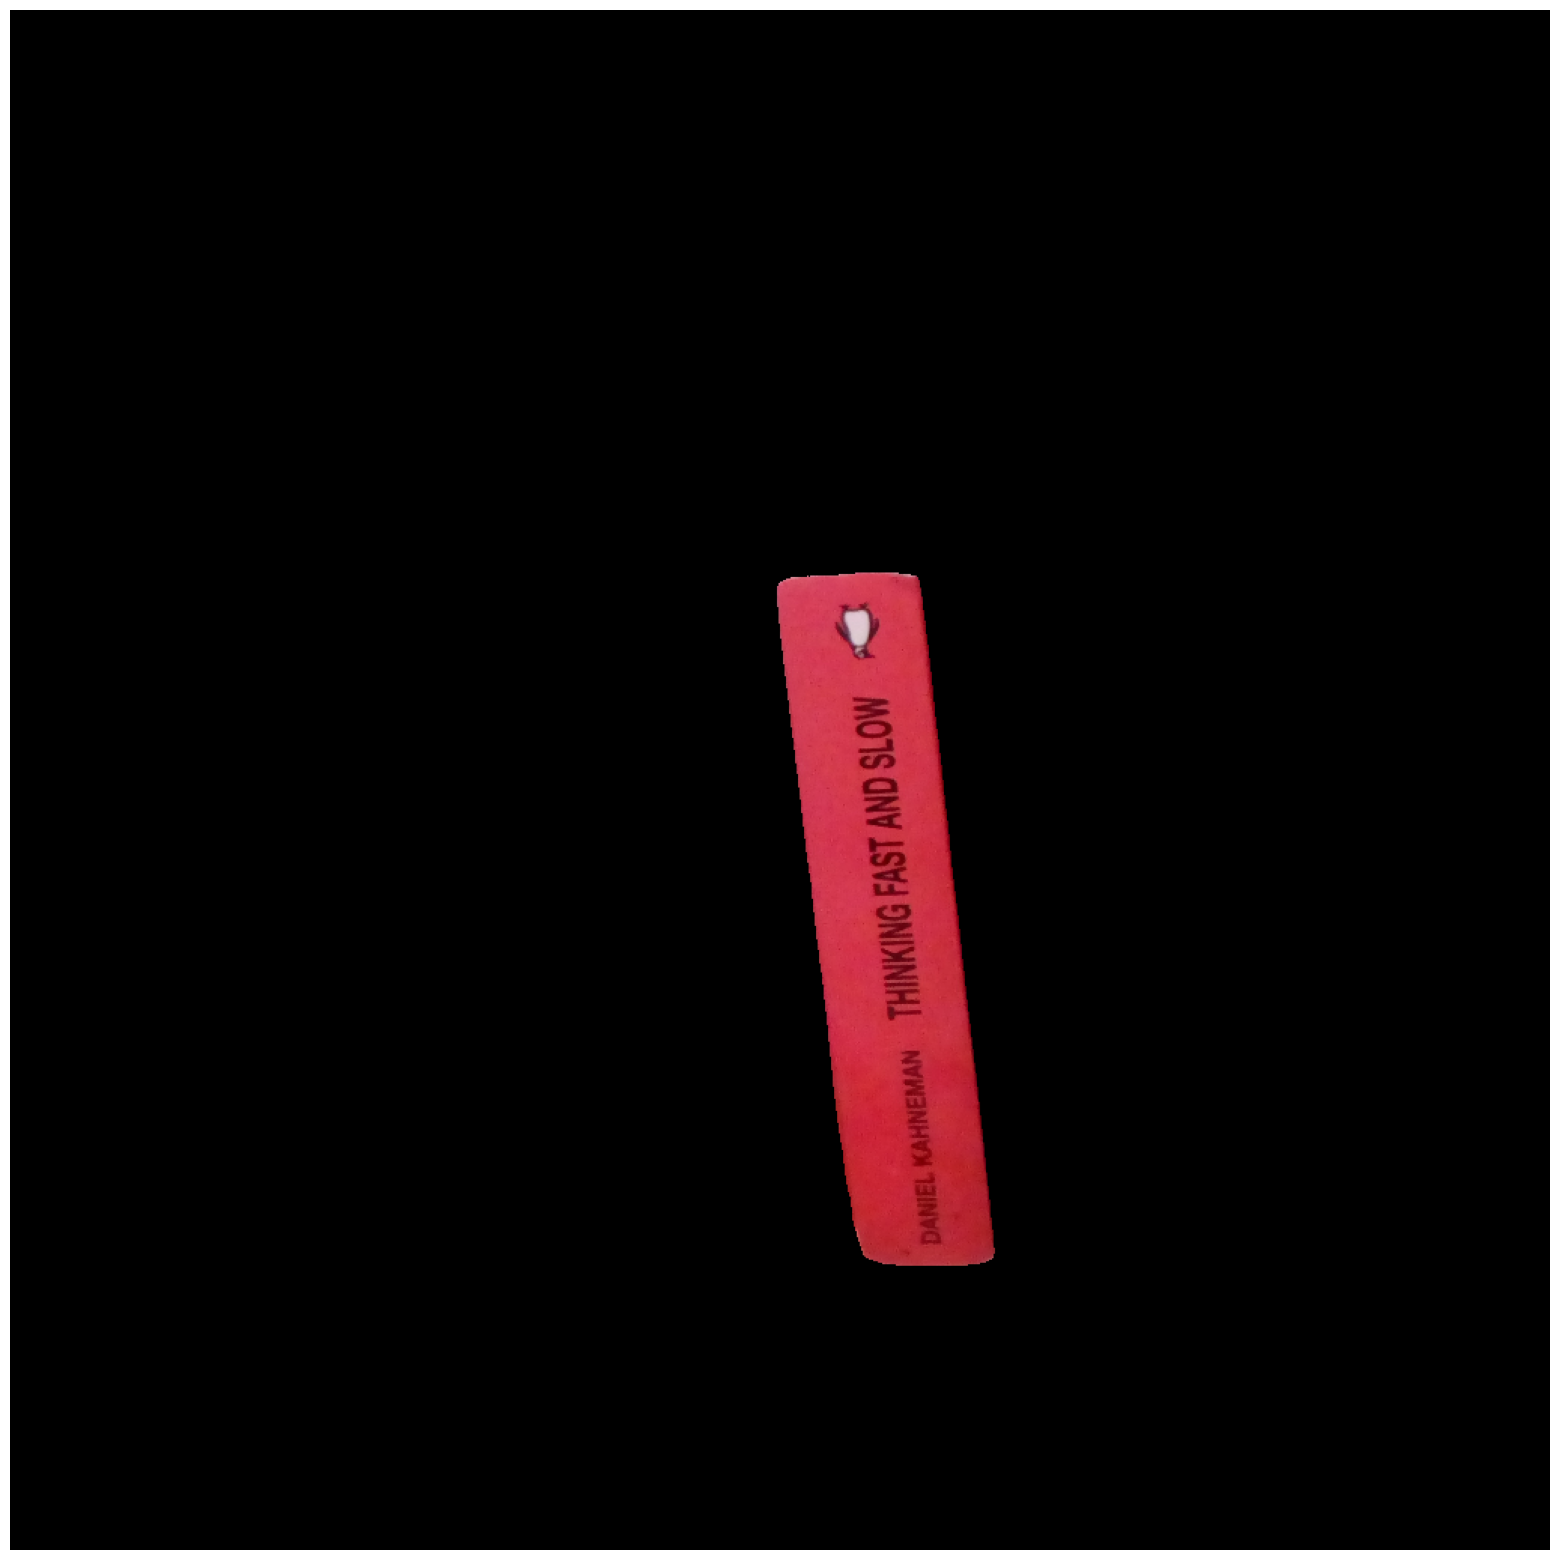

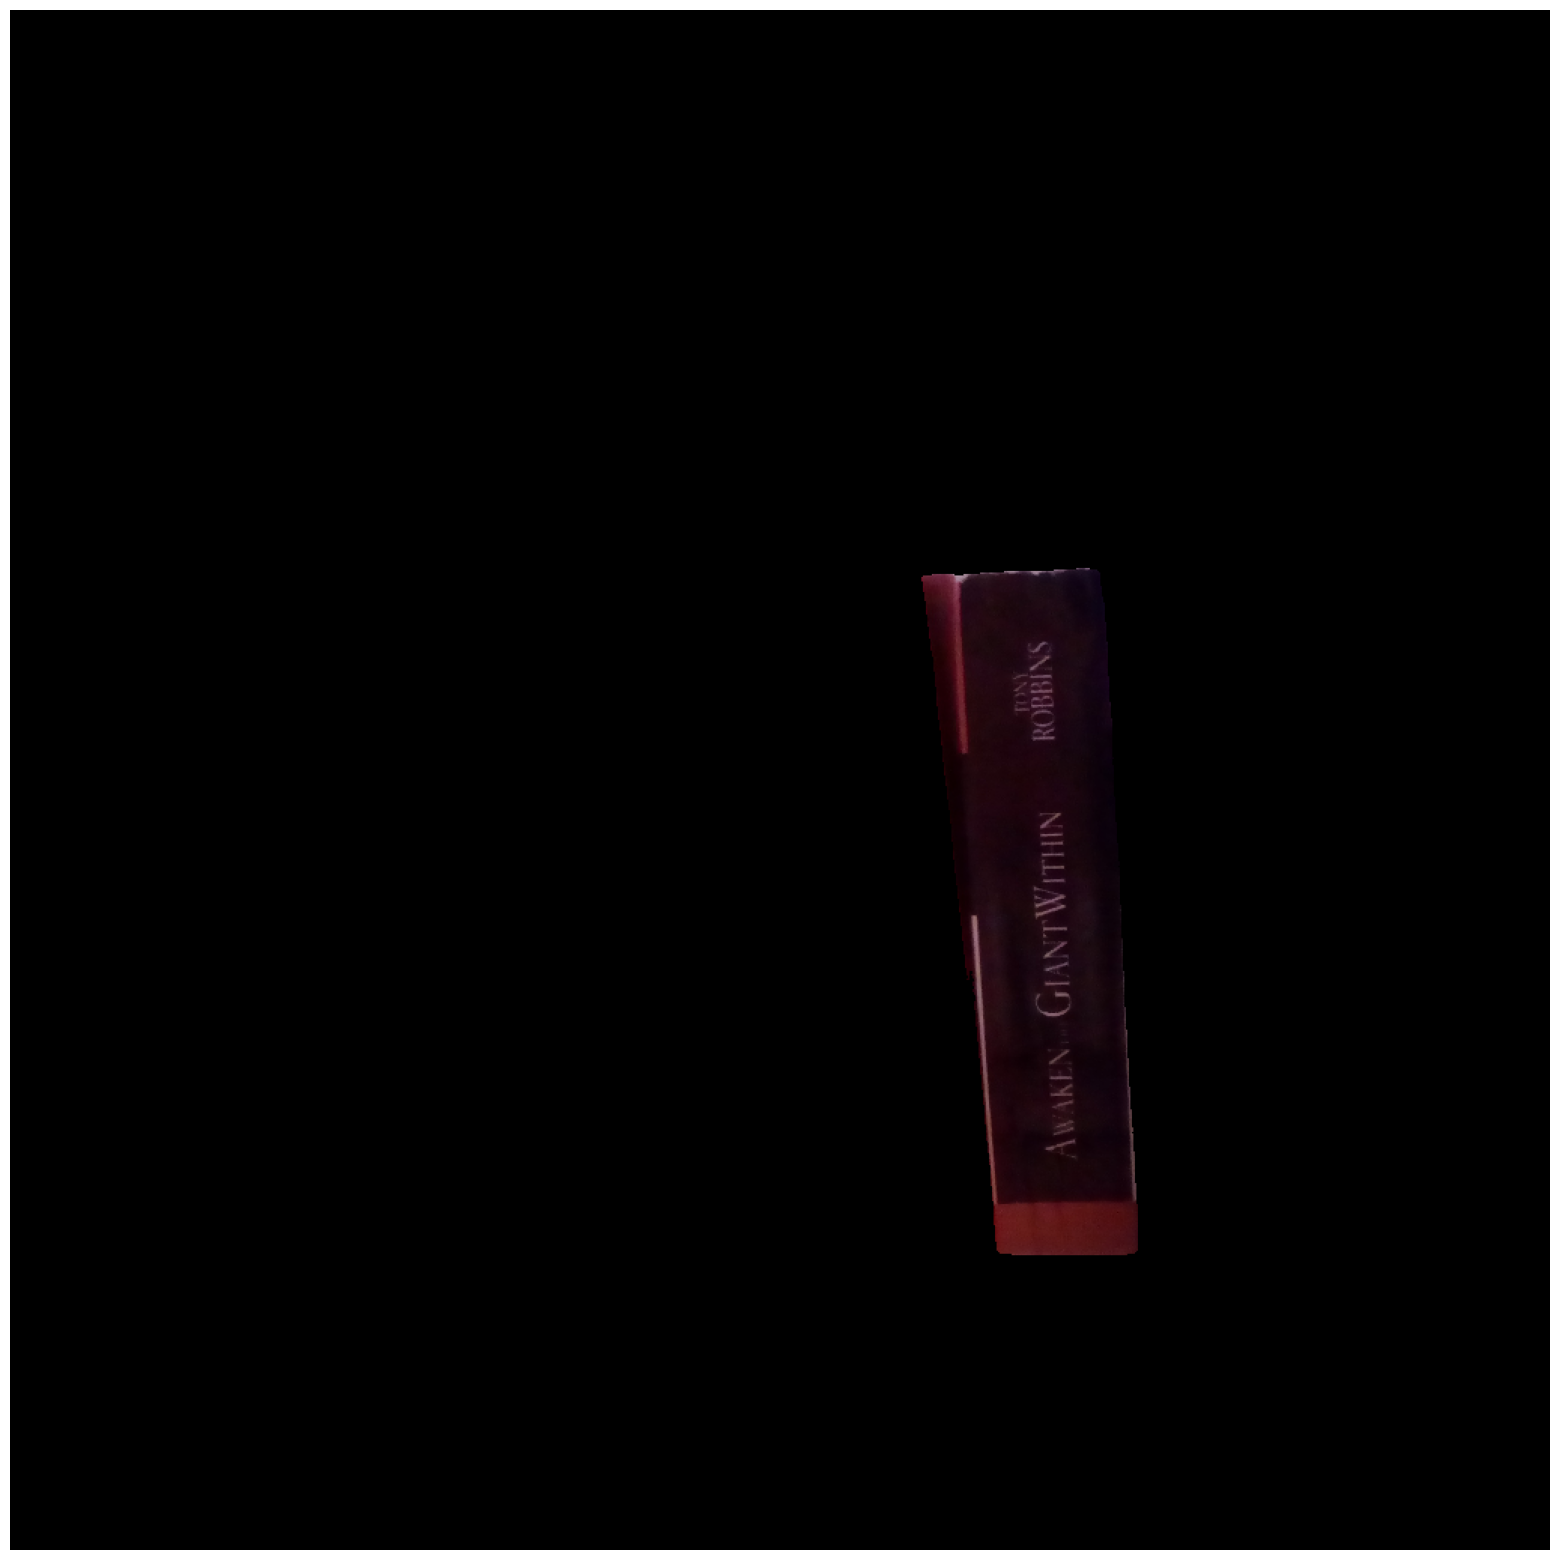

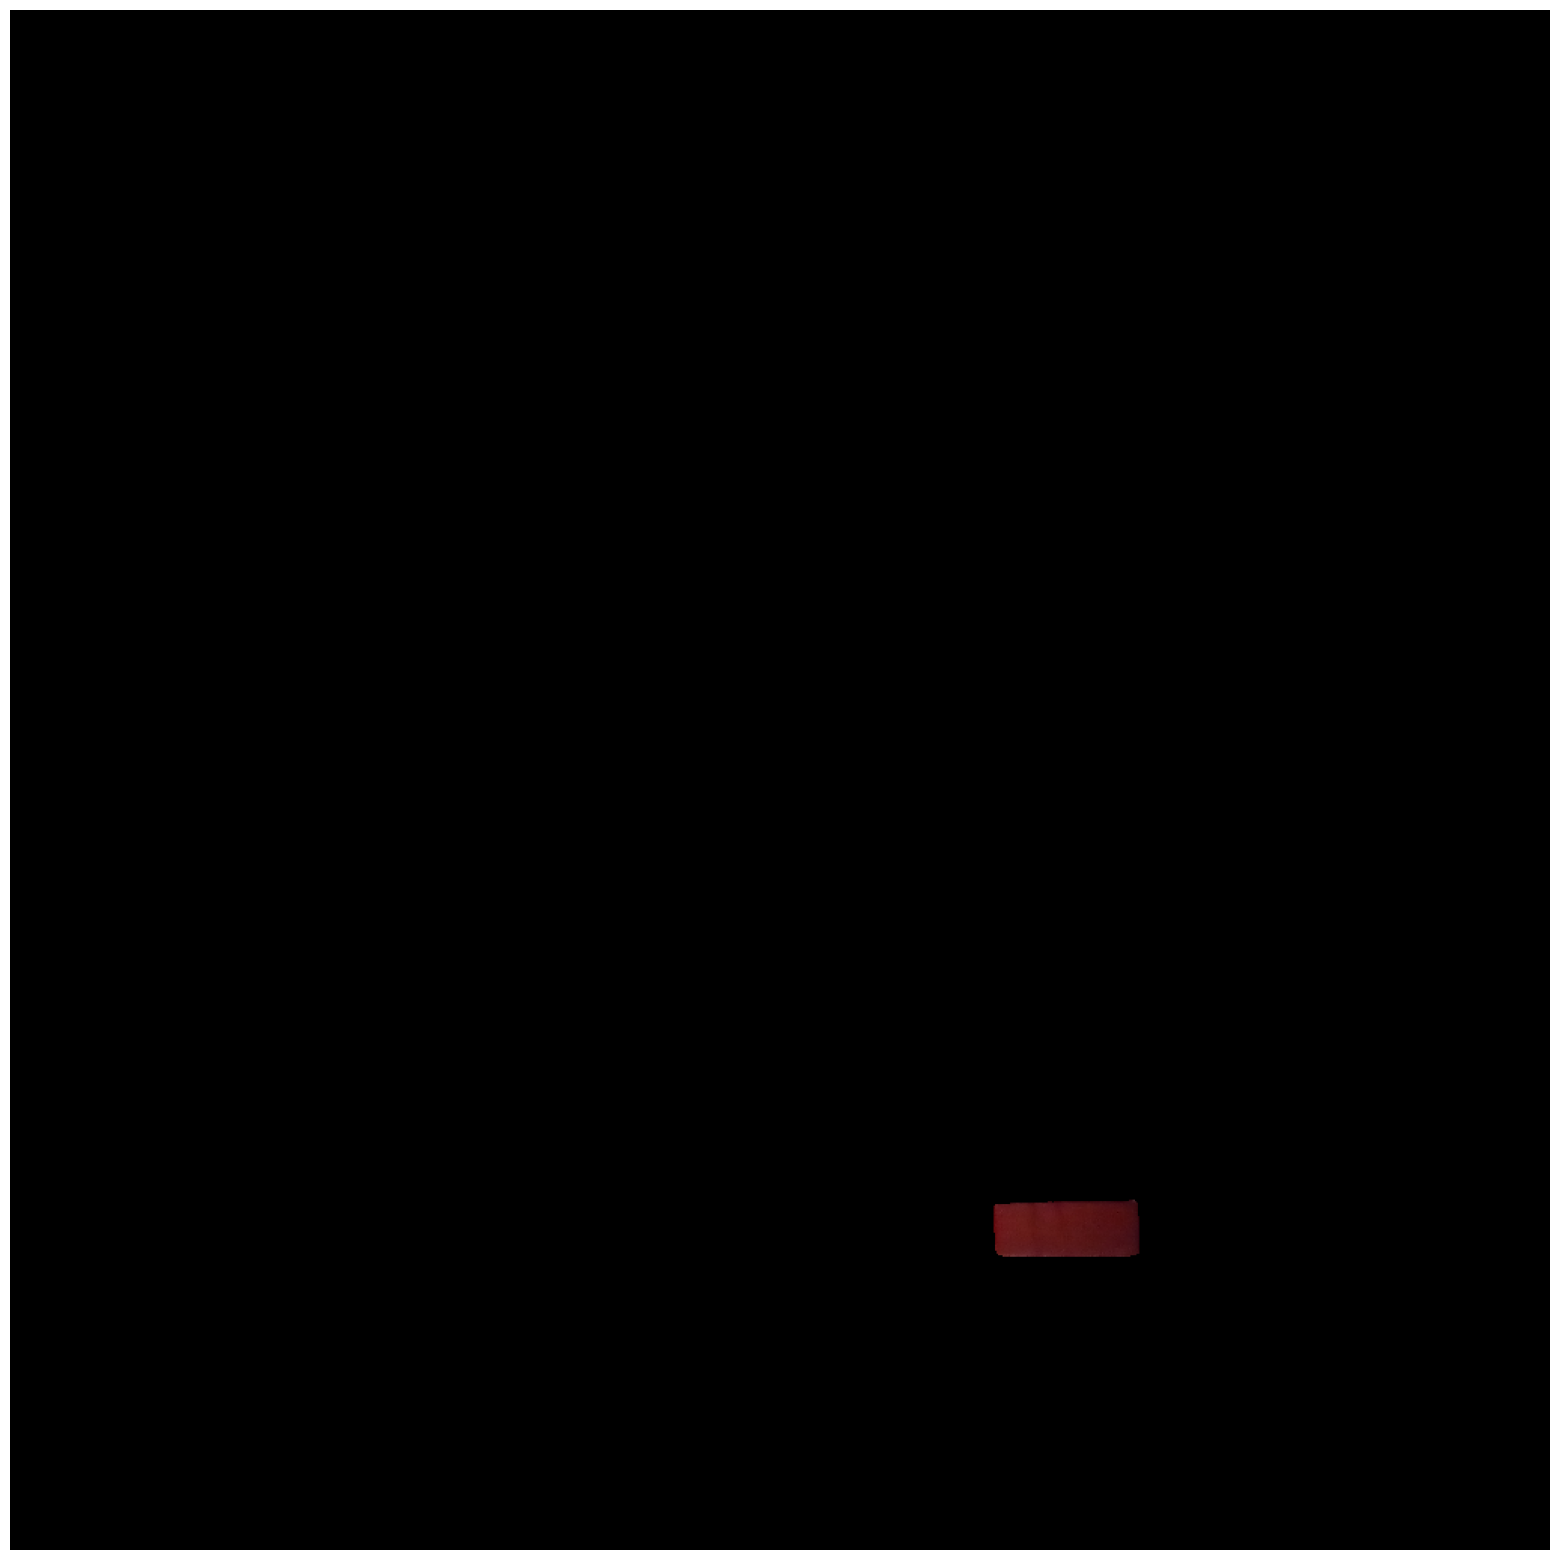

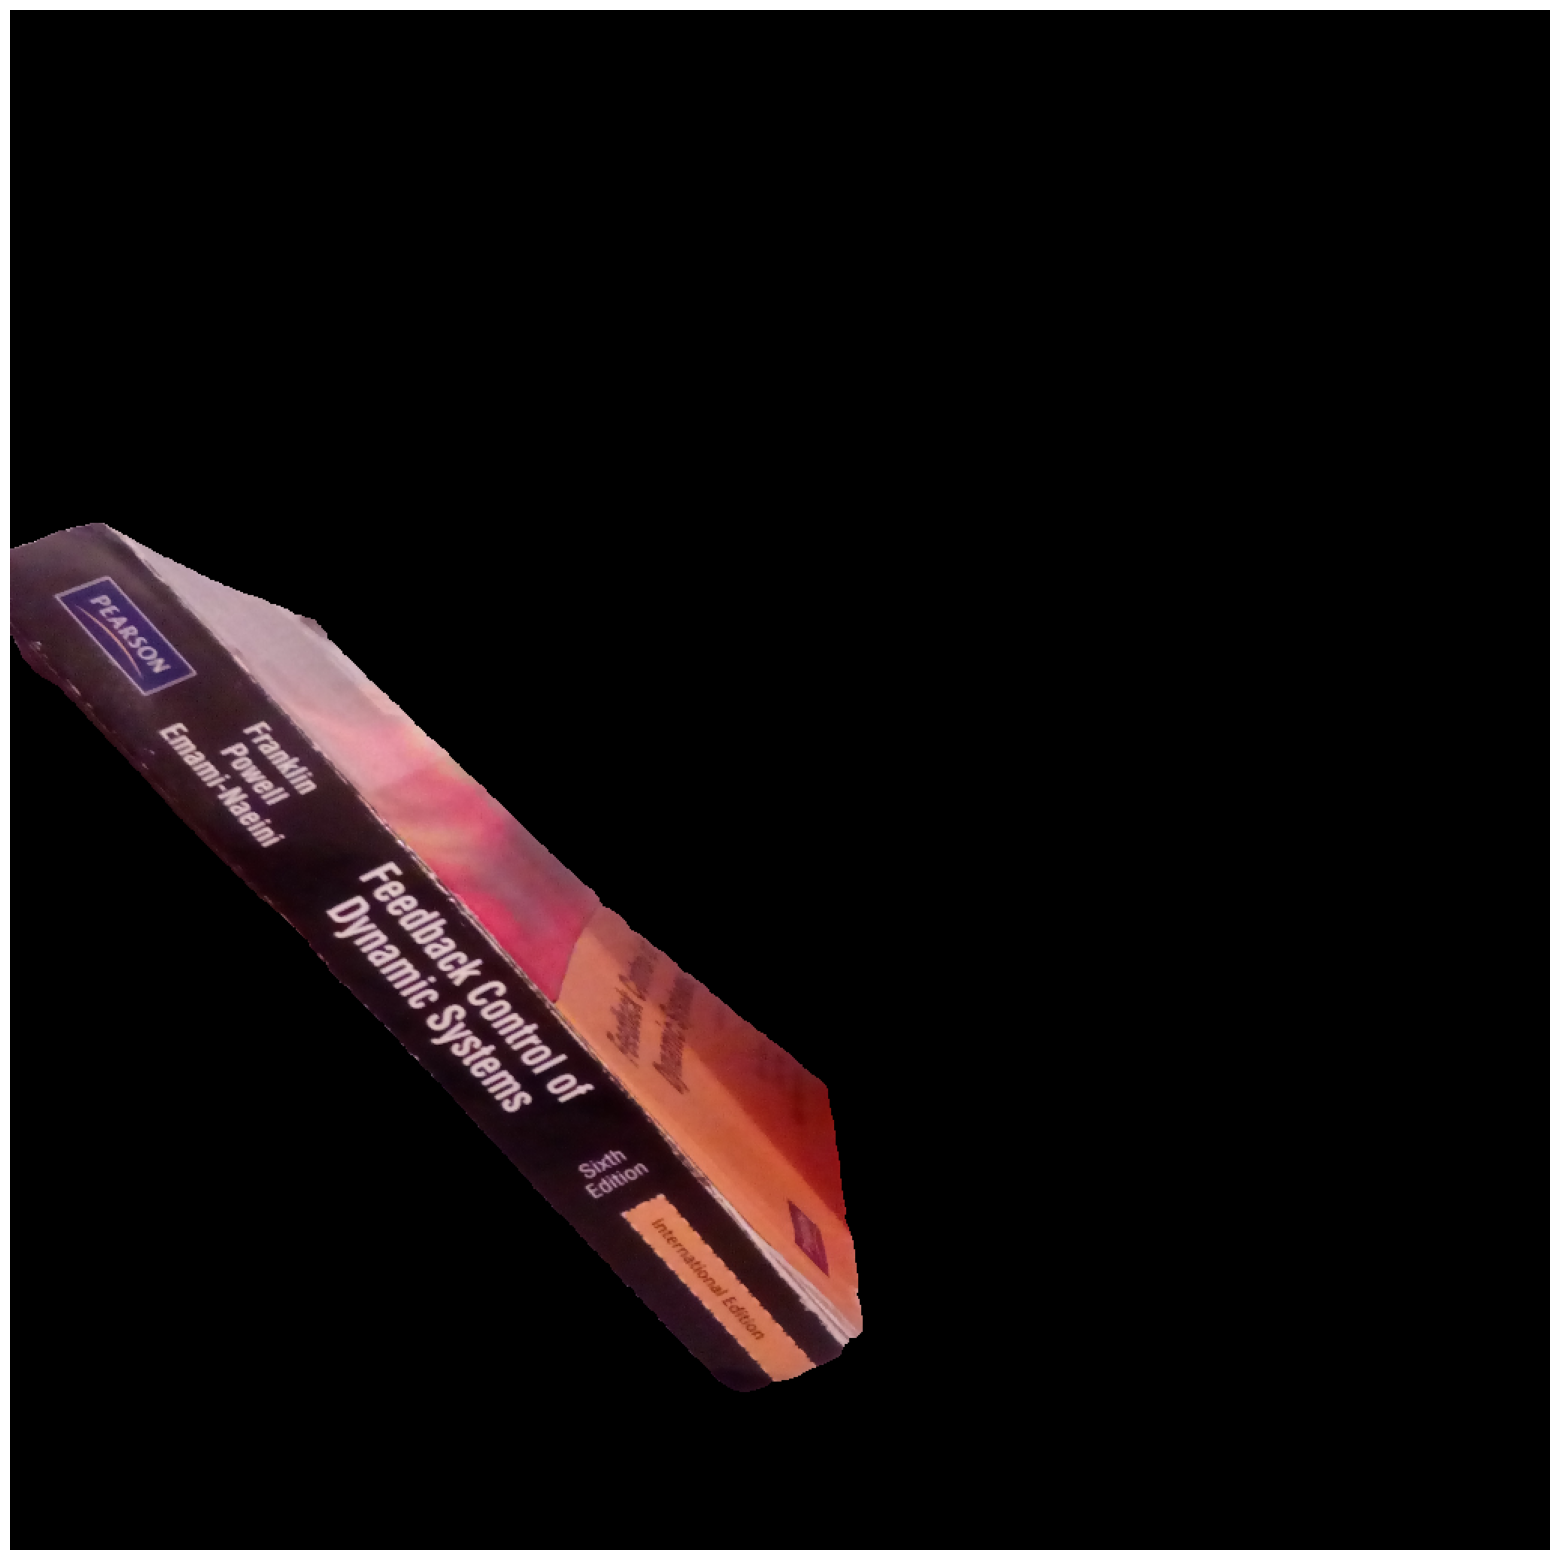

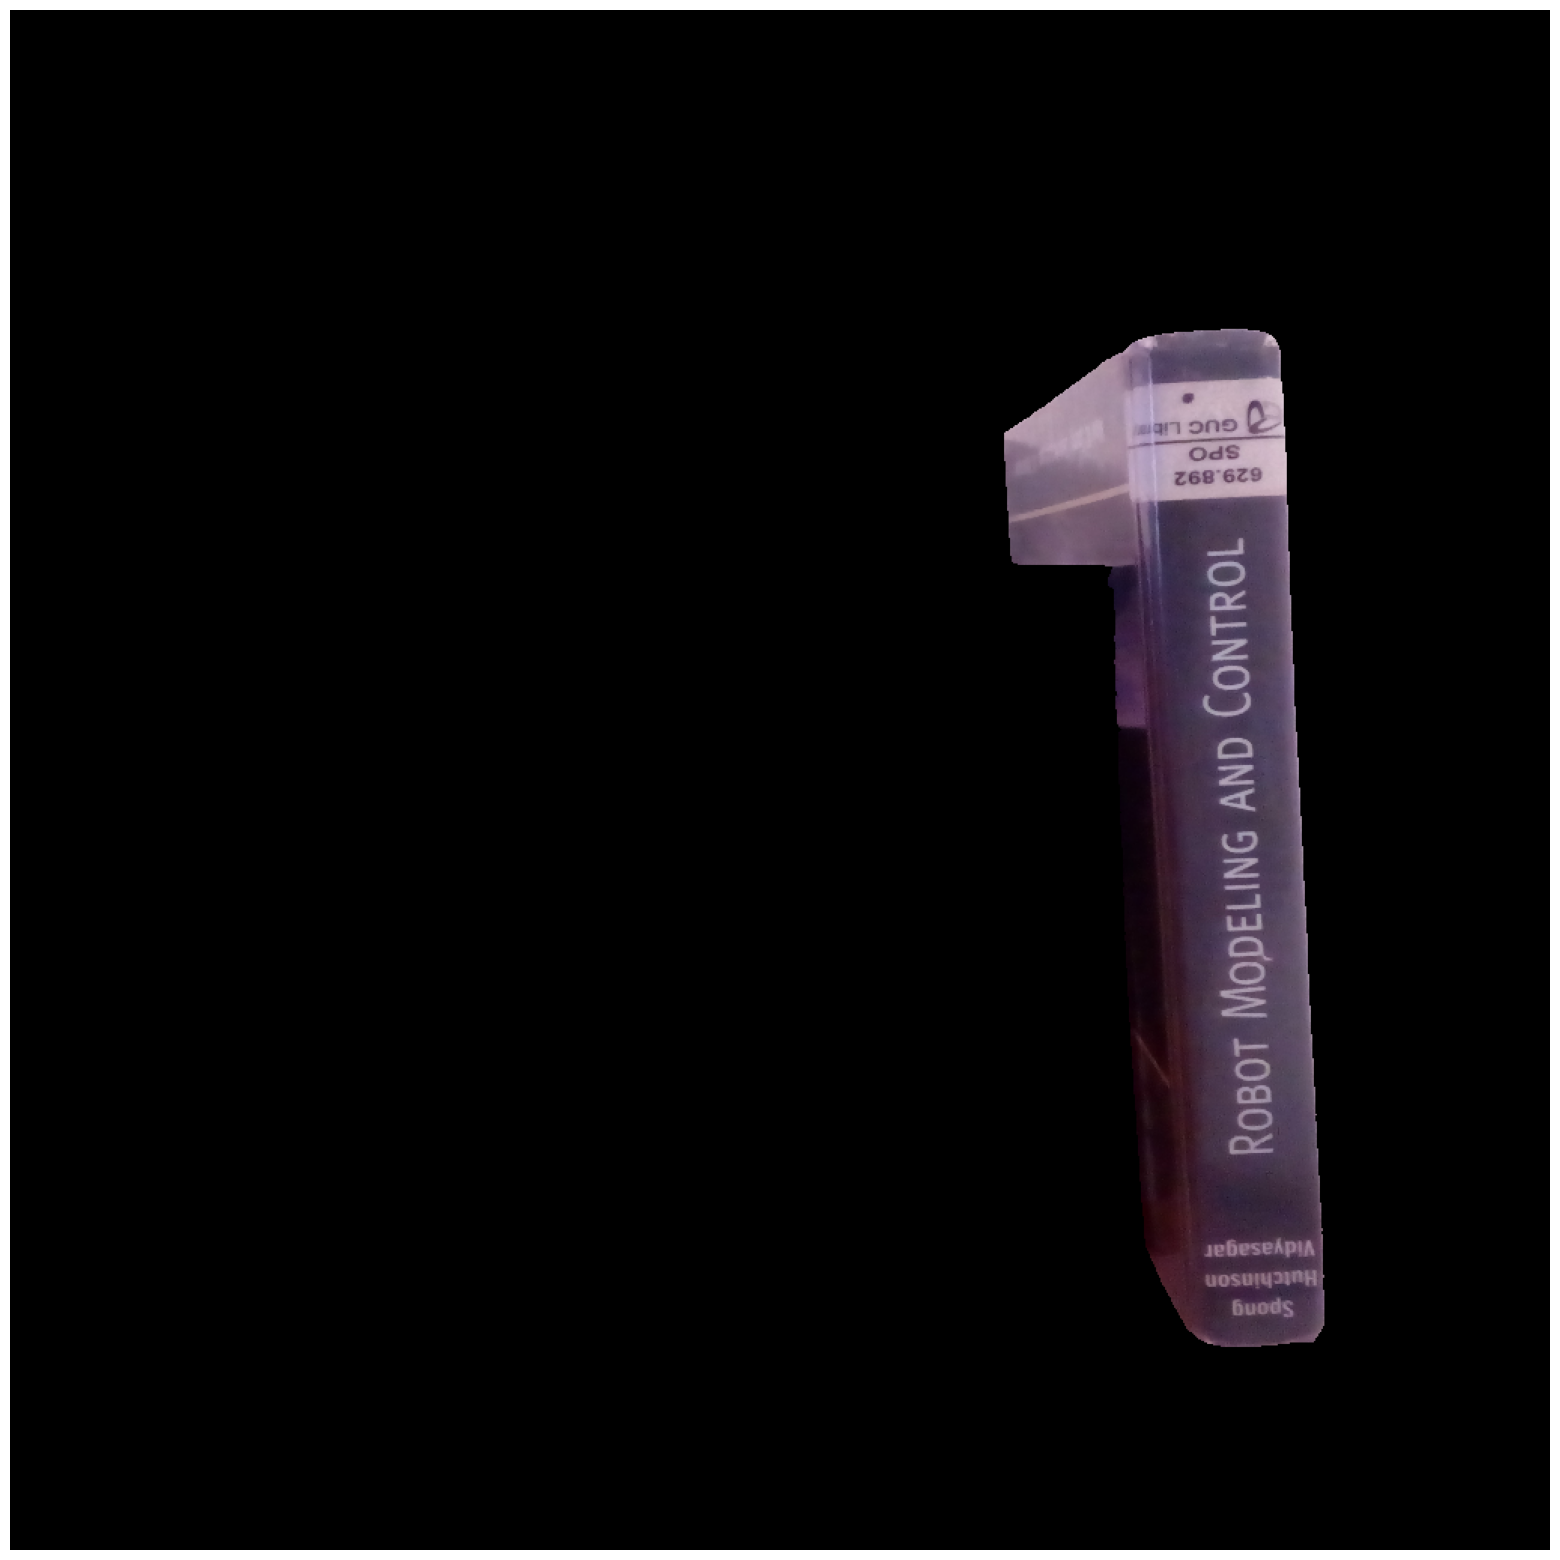

In [12]:
for book in book_segments:
    show_annotated(book)

After running the Google Cloud Vision API to detect a set of pages and their blocks that have text, organize the data into an array of blocks with their corresponding text and coordinates, and then scale the coordinates as needed:

In [33]:
def create_blocks(pages, scaling_x, scaling_y):
    # Iterate through pages and all of their blocks
    blocks = []
    for page in pages:
        for block in page.blocks:
            # Calculate the center of the block
            min_x = min([vertex.x for vertex in block.bounding_box.vertices])
            min_y = min([vertex.y for vertex in block.bounding_box.vertices])
            max_x = max([vertex.x for vertex in block.bounding_box.vertices])
            max_y = max([vertex.y for vertex in block.bounding_box.vertices])
            center_x = min_x + (max_x - min_x) / 2
            center_y = min_y + (max_y - min_y) / 2

            # Iterate through the paragraphs for this block
            paragraphs = []
            for paragraph in block.paragraphs:
                # Iterate through the words for this paragraph
                paragraph_text = ""
                for word in paragraph.words:
                    word_text = "".join([symbol.text for symbol in word.symbols])
                    print("\t\tWord text: {} (confidence: {})".format(word_text, word.confidence))
                    # Iterate through the character symbols for this word
                    for symbol in word.symbols:
                        print("\t\t\tSymbol: {} (confidence: {})".format(symbol.text, symbol.confidence))
                    paragraph_text += word_text + " "
                paragraphs.append(paragraph_text[:-1])
                print("\nParagraph text: {}".format(paragraph_text))

            # Create dictionary to store data for this block
            this_block = dict()
            this_block["paragraphs"] = paragraphs
            this_block["center_x"] = int(center_x * scaling_x)
            this_block["center_y"] = int(center_y * scaling_y)
            blocks.append(this_block)
            print("Block text: {}".format(paragraphs))
    return blocks

Detect areas with text from a given image using Google Cloud's Vision API and generate the blocks using the function above:

In [34]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    client = vision.ImageAnnotatorClient()

    # Create a BytesIO object and load it with the image content
    with open(path, "rb") as image_file:
        content = image_file.read()
    image_io = io.BytesIO(content)
    image = Image.open(image_io)

    # Get the size of the image
    image_size = image.size
    image = vision.Image(content=content)
    response = client.text_detection(image=image)

    # Open the results from Vision API
    with open("response.json", "w") as f:
        f.write(str(response))
    texts = response.text_annotations

    # Print out all the phrase identified in the image and their locations
    print("Texts:")
    for text in texts:
        print(f'\n"{text.description}"')
        vertices = [f"({vertex.x},{vertex.y})" for vertex in text.bounding_poly.vertices]
        print("bounds: {}".format(",".join(vertices)))

    # Iterate through pages and all of their blocks
    pages = response.full_text_annotation.pages
    blocks = create_blocks(pages, 1024 / image_size[0], 1024 / image_size[1])

    # Respond accordingly to an error message
    if response.error.message:
        raise Exception(
            "{}\nFor more info on error messages, check: "
            "https://cloud.google.com/apis/design/errors".format(response.error.message)
        )

    return blocks

Print out the result of detecting the text from the original image:

In [35]:
detected_blocks = detect_text("original_image.jpg")
print(detected_blocks)

Texts:

"Spong
Hutchinson
Vidyasagar
International Edition
Sixth
Edition
Powell
Franklin
Emami-Naeini
Dynamic Systems
Feedback Control of
DANIEL KAHNEMAN THINKING FAST AND SLOW
THE
AWAKEN GIANT WITHIN
TONY
ROBBINS
ROBOT MODELING AND CONTROL
SPO
GUC Lib
629.892
PEARSON"
bounds: (124,862),(2079,862),(2079,2821),(124,2821)

"Spong"
bounds: (2045,2768),(1944,2774),(1942,2733),(2043,2727)

"Hutchinson"
bounds: (2079,2704),(1900,2712),(1899,2678),(2078,2670)

"Vidyasagar"
bounds: (2075,2640),(1897,2644),(1896,2606),(2074,2602)

"International"
bounds: (1037,2557),(1145,2716),(1125,2729),(1017,2571)

"Edition"
bounds: (1149,2721),(1207,2806),(1186,2820),(1128,2735)

"Sixth"
bounds: (898,2454),(963,2408),(980,2431),(915,2478)

"Edition"
bounds: (910,2493),(1002,2436),(1018,2462),(926,2519)

"Powell"
bounds: (364,1549),(446,1670),(414,1691),(333,1570)

"Franklin"
bounds: (400,1503),(495,1643),(462,1665),(368,1525)

"Emami"
bounds: (267,1507),(350,1628),(317,1651),(234,1530)

"-"
bounds: (350,16

Match the corresponding block for the given text, considering different permutations of the block paragraphs:

In [36]:
def match_text_to_blocks(text, blocks):
    for block in blocks:
        permutations = itertools.permutations(block["paragraphs"])
        for permutation in permutations:
            perm = ' '.join(list(permutation))
            if text.lower() in perm.lower():
                return block
    return None

Retrieve the block for a given sample text:

In [37]:
block = match_text_to_blocks(sample_text, detected_blocks)
print(block)

{'paragraphs': ['ROBOT MODELING AND CONTROL'], 'center_x': 814, 'center_y': 556}


With the given coordinates, find the book segment that has the block and display it:

In [44]:
correct_segment = None
for book in book_segments:  
    pass
    # center_pixel = book[block['center_x'], block['center_y']]
    # print(center_pixel)
    # if (center_pixel != [0, 0, 0]).all():
    #     correct_segment = book
    #     break
# show_annotated(correct_segment)